In [0]:
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import skimage.transform
from xml.etree import ElementTree
import xml.etree.ElementTree as ET
from google.colab import files
from google.colab import drive
drive.mount('/content/drive/')

#API Keys
colton_api = 'X1-ZWz1gyz7nh1z4b_4rdd9'
alex_api = 'X1-ZWz180mx6q4ky3_7ucak'
nic_api = 'X1-ZWz1gzwn8brg23_8l13j'


In [0]:
#Get zillow IDs by zipcode, returns up to 25 zillow ids by zip
#Returns list of unique zillow ids
def getZillowIdsByZip(zipcode):
  address = 'st' #generic street, so it's not limited to a street name
  citystatezip = 'Pittsburgh+%2CPA+%2C' + str(zipcode)
  url = 'http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id='+alex_api+'&address='+address+'&citystatezip='+citystatezip
  headers = {'Content-Type': "application/x-www-form-urlencoded", 'Accept': "application/xml"}
  response = requests.get(url)
  root = ET.fromstring(response.content)
  
  unique_zids = set()
  #Parse XML resposne
  for child in root:
    for i in child:
      for j in i:
        for k in j:
          #print("\t\t\t",k.tag, k.text)
          if (k.tag == 'zpid'):
              zpid = k.text
              unique_zids.add(zpid)
  return list(unique_zids)




#Get a list of images (up to 5 provided by zillow) based on a zillow id
#Returns a list of image urls
def getImageLinks(zillow_id):
  #Send API Request
  url = 'http://www.zillow.com/webservice/GetUpdatedPropertyDetails.htm?zws-id='+alex_api+'&zpid='+str(zillow_id)
  headers = {'Content-Type': "application/x-www-form-urlencoded", 'Accept': "application/xml"}
  response = requests.get(url)
  root = ET.fromstring(response.content)
  
  img_urls =[]
  #Parse XML resposne
  for child in root:
    for i in child:
      if(i.tag == 'zpid'):
        zid = i.text
      for j in i:
        for k in j:
          if (k.tag == "url"):
            img_url = k.text
            img_urls.append(img_url) 
            
  return img_urls
    

    
#Get an array representation of an image based on the image url
#Returns a numpy array for the image passed to it  
def getImageArray(img_url):
    response = requests.get(img_url)
    img = np.array(Image.open(BytesIO(response.content)))
    return img
    

    
#Displays the image based on the numpy representation of the image
def showImage(img):
    print("\nImage size", img.shape)
    plt.imshow(img)
    plt.show()
  
   
  
#Parse XML resposne
def zillow_parser(root):
  '''
  This parser locates data on each api call made. The data is then 
  returned as a list that can be added as a new row in a dataframe. 
  '''
  
  # make all variables None to start
  zid, street, zipcode, city, state, latitude, longitude, price, useCode, bedrooms, bathrooms, lotSizeSqFt, yearBuilt, numFloors, numRooms, left_over_tags, home_desc = None
  finishedSqFt, parkingType, heatingSystem, coolingSystem, appliances, floorCovering, rooms,exteriorMaterial, heatingSources, architecture, roof, basement, yearUpdated = None

  for child in root:
    img_urls =[]
    left_over_tags = []
    other_loc_detail = []
    for i in child:
      if(i.tag == 'zpid'): # save zillow id
        #print('Getting zpid:',i.text)
        zid = i.text
      elif(i.tag == 'address'): # save address information
        #print('Getting address information')
        for loc_detail in i:
          if loc_detail.tag == 'street':
            street = loc_detail.text
            #print('Street:',street)
          elif loc_detail.tag == 'zipcode':
            zipcode = loc_detail.text
          elif loc_detail.tag == 'city':
            city = loc_detail.text
          elif loc_detail.tag == 'state':
            state = loc_detail.text
          elif loc_detail.tag == 'latitude':
            latitude = loc_detail.text
          elif loc_detail.tag == 'longitude':
            longitude = loc_detail.text
      elif i.tag == 'price': # save price data
        #print('Getting price data')
        price = i.text
        print('Price:',price)
      elif i.tag == 'editedFacts': # save feature data
        #print('Getting feature data')
        for fact in i:
          if fact.tag == 'useCode':
            useCode = fact.text
          elif fact.tag == 'bedrooms':
            bedrooms = fact.text
          elif fact.tag == 'bathrooms':
            bathrooms = fact.text
          elif fact.tag == 'lotSizeSqFt':
            lotSizeSqFt = fact.text
          elif fact.tag == 'yearBuilt':
            yearBuilt = fact.text
          elif fact.tag == 'numFloors':
            numFloors = fact.text
          elif fact.tag == 'numRooms':
            numRooms = fact.text
          elif fact.tag == 'finishedSqFt':
            finishedSqFt = fact.text
          elif fact.tag == 'parkingType':
            parkingType = fact.text
          elif fact.tag == 'heatingSystem':
            heatingSystem = fact.text
          elif fact.tag == 'coolingSystem':
            coolingSystem = fact.text
          elif fact.tag == 'appliances':
            appliances = fact.text
          elif fact.tag == 'floorCovering':
            floorCovering = fact.text
          elif fact.tag == 'rooms':
            rooms = fact.text
          elif fact.tag == 'exteriorMaterial':
            exteriorMaterial = fact.text
          elif fact.tag == 'heatingSources':
            heatingSources = fact.text
          elif fact.tag == 'architecture':
            architecture = fact.text
          elif fact.tag == 'roof':
            roof = fact.text
          elif fact.tag == 'basement':
            basement = fact.text
          elif fact.tag == 'yearUpdated':
            yearUpdated = fact.text
          else:
            left_over_tags.append(fact.tag)
      elif i.tag == 'homeDescription': # save home description
        #print('Getting home desc')
        home_desc = i.text
      elif i.tag == 'images': # save image data
        #print('Getting img urls')
        for image_tag in i:
           if image_tag.tag == 'image':
              for url_tag in image_tag:
                if url_tag.tag == 'url':
                  img_urls.append(url_tag.text)               
  # Organize the data
  collected_data = [zid,street,zipcode,city,state,latitude, longitude,price,useCode,
                    bedrooms,bathrooms, rooms, basement, lotSizeSqFt, finishedSqFt, yearBuilt, yearUpdated,
                    numFloors,numRooms, appliances, heatingSystem, heatingSources, coolingSystem, 
                    floorCovering, exteriorMaterial, roof, parkingType, architecture, left_over_tags, home_desc, img_urls]
  
  return collected_data


Image size (1152, 1536, 3)


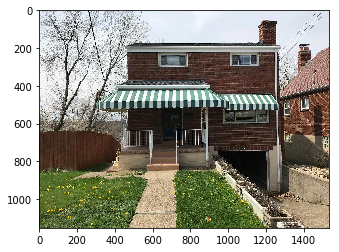

In [0]:
#Call functions to get zillow ids by zip codes

# zipcodes = [15201, 15202, 15204, 15205, 15208, 15210, 15203, 15206, 15207, 15209, 15211, 15214, 15216, 15212, 15213, 15215, 15217, 15218, 15219, 15220, 15222, 15223, 15224, 15226, 15221, 15225, 15227, 15229,
#              15230, 15231, 15233, 15238, 15228, 15232, 15234, 15235, 15236, 15237, 15239, 15240, 15242, 15243, 15253, 15254, 15241, 15244, 15250, 15251, 15252, 15255, 15257, 15258, 15259, 15260, 15261, 15262, 
#              15264, 15270, 15272, 15274, 15279, 15281, 15289, 15290, 15295, 15265, 15267, 15268, 15275, 15276, 15277, 15278, 15282, 15283, 15286]

# zillow_id_list = []
# for zipcode in zipcodes[0:3]:
#   zillow_id_list += getZillowIdsByZip(zipcode)

# print(len(zillow_id_list))
# print(zillow_id_list)


#Calls functions to return first image for a zillow id
https://photos.zillowstatic.com/cc_ft_1536/ISma6214cuulvt0000000000.webp
showImage(getImageArray('https://photos.zillowstatic.com/cc_ft_1536/ISuc5dd1d0zwwt0000000000.webp'))


In [0]:
  #Get specific response for a zillow ID
  url = 'http://www.zillow.com/webservice/GetUpdatedPropertyDetails.htm?zws-id='+alex_api+'&zpid='+'11544891'
  headers = {'Content-Type': "application/x-www-form-urlencoded", 'Accept': "application/xml"}
  response = requests.get(url)
  root = ET.fromstring(response.content)
  
  data = zillow_parser(root)
  all_data.append(data)

In [0]:
#All zillow ids to make calls to. 
#Created separate groups because API has 1,000 request limit per day
img_zid_dict = {}

##Zillow IDs 
zillow_ids_group1 = [11515112,11595078,11515064,11609826,11474294,11445608,11361406,11395734,11335930,11353960,11417252,11381723,11645331,11445295,11337241,11444919,11407634,2086931082,11528652,164223077,11659372,11474932,11648948,11342623,11373904,11645164,11649248,11646964,11628859,11631846,11382096,118479537,11628961,11522884,11549918,11475977,11514569,164528616,11514253,11441717,11358482,11635965,11436515,11403099,11366604,11384780,11317244,11624768,11514516,11634978,11362297,11626774,11271630,11528242,11307343,11534069,2089138152,11516512,164713797,11428666,11308802,11413529,11566332,11394757,11432411,11455875,11372531,11516491,11479062,11330563,11519923,11369601,11396171,11396066,11444715,164713773,11483338,11373639,11475881,11325688,81843560,11335050,11551019,11600227,11454108,11529271,11338478,2094510626,11367012,11629448,11323795,11554526,164627136,11343068,11307239,11448815,11296403,11476041,11345130,11344933,11636317,11341781,11362681,11369506,11323472,11332992,2088811769,11335121,11334785,11547480,11363485,11323474,11333742,123703284,11586074,11383642,11417312,11408082,11382056,11636102,87992297,11404775,11278529,11270000,11519426,11405327,11429054,11554262,11366707,11644955,11326236,11376206,11476798,11650315,11647431,242631191,11387957,11344280,11399167,104362429,11529233,11330905,11333224,11517108,11388408,11307635,11271483,11358685,11316003,11388591,11383456,11323275,164346129,11468425,11514332,11325331,2088106343,11562297,11404412,11482307,11296867,11361604,11352419,11514007,11318707,11635325,11402566,11437202,11454374,11529794,11512502,11513631,11626840,11479887,11515312,11307317,11656671,11473468,11269981,11358332,11262647,11534076,11344099,11383037,11626584,11650609,242630578,11513745,11525306,11414853,11277992,11307021,11525034,11524968,11270971,11326402,11650896,11639675,11343991,11647341,81843485,11382759,11361440,119343696,11476443,11528587,11388465,11369007,11345461,119111802,11362169,11376756,11629353,11566437,11376207,11414367,11287976,11626805,246262512,11278491,11584762,11514603,87987538,11289969,11585988,11366403,121886498,11603721,11282010,11343248,11316105,11354649,2088871349,11318468,11337563,2085878703,11625529,11358320,11373908,11291029,11599108,11515078,11290664,11397672,164713774,11343518,164668847,2088172808,11366459,11333656,11515720,11356802,11288323,11562298,11336694,11480137,11361694,11528586,11404678,11358274,11408066,11345787,11445756,11333025,11622358,11361919,11343215,11479063,11636237,11454625,11361769,11420130,121888288,11366402,11624936,11515833,11361531,11528745,104360889,11291479,11352002,11344988,11650581,11629611,11390910,11645078,11329215,11650198,11271548,11562549,11417338,11293293,11428709,11488364,164713795,164580705,11585889,164203818,11329351,11483056,11323885,11395818,11446267,11512570,11399007,11372545,11342141,11529715,11402248,11314859,11345173,11519984,11474633,11626232,11398638,11269632,11418447,11468667,11387948,11551096,11649132,11650850,11475420,87994491,11445145,11323244,11334347,11361881,11323840,11627037,11441877,11557360,11338153,11333471,11332760,11513629,11336086,164591898,11611616,11414544,11488327,11356806,11454163,11388546,11562192,11336744,11445799,11367536,11629875,11395243,11517019,11649055,119346954,11290058,11290344,11344650,11479940,11382211,11324933,92380645,11414179,11528188,11649030,11282178,87991039,11440085,11605744,11626690,11383528,11395860,11327977,11346033,59835435,11475348,11345036,11391233,11269669,11481960,11513734,11473630,11550679,11428120,11414393,11367404,11363455,11339358,11630562,11436122,11437323,11341692,11550821,11358208,11597571,11325316,11343006,11454911,11394361,11640140,11327065,11281551,11326548,11437256,11352523,11562141,11411482,11376274,11550015,11318854,2088856319,11473691,11524337,2089535405,164560119,11387617,11524770,11334804,11515114,11322571,11473753,11474635,11414406,11287744,11455209,11311872,11520718,11325926,11327803,11396345,11556180,11271965,59836824,11483869,121887712,11436053,2086973625,11446337,11362527,11345260,11382074,11323214,11445915,11338682,11611471,11344000,2086529842,11358742,11650183,11513164,11307539,11345136,11334955,72262937,2086505644,11337951,11626150,11376722,11307487,11409139,11346234,11334110,11317255,11287537,11436563,11512518,11514450,11288189,11310965,11479754,119344541,11436067,11588129,11649678,11343489,11337989,11506069,11505739,11529771,11342692,11362440,11290378,2088749063,11339964,11407618,11544400,11515288,11344510,11366457,11586257,11287614,11441432,11288152,11403491,74720378,11405329,11345426,11454869,11269852,11475324,11437309,11328058,11361917,11290599,11473696,11326495,11341066,11445506,242630560,11289353,11316182,11554325,11561816,11524511,11366558,119346711,11346042,11323766,164637649,11513521,11308040,11335419,11445415,11296779,11306443,11597092,11361497,11291636,11441820,11626437,11515558,11290788,11528588,11475237,11373599,11388909,11479331,11640318,11513673,11550527,11334931,11369029,67344702,11454478,11482546,119345717,2087957108,11313414,11383792,11656515,11344296,11435391,11395870,11287450,11327762,11630556,11291989,11639977,11656669,11515271,164332994,11291438,11345683,11335523,11269698,11381947,164713788,11520619,11480087,11323069,11525003,11326478,11308658,11291310,2097604287,11392449,11291502,11597750,11341161,11402660,11588314,121887192,11647776,11479729,11454916,11520579,11515391,11338517,11291849,11514365,11520821,11361451,11519973,11333643,11290086,11394715,11414534,11620402,11540003,11352244,11344648,11650004,11445143,11475708,164587379,11474968,11414246,11335661,11314702,11317090,11428053,11281668,11584766,2088461772,11640071,11363453,11631209,11553920,11343839,87994480,11610980,11528693,11307475,11441310,11278067,11308263,11649390,11519866,11428477,11306775,11649770,11291844,11650705,11308378,11529094,11482656,11514433,11520679,164713861,11344684,11656502,11361654,242630386,11445859,11311988,11318927,11383063,11324765,11513601,11388014,11588553,11587704,11631630,11551071,11514612,11345116,2089941018,11417831,11414102,11455064,87989550,11440463,11334880,11382325,11557087,11519958,11483579,11324241,11483719,11335707,11631159,11650671,11343243,242630411,11363451,11355729,11345297,11524972,11413423,11402548,87992325,11405308,249780179,11417850,11636722,11635520,11335772,11417529,11358033,11529134,11475210,11414474,94811034,11305547,2086932625,11520896,11514754,11262661,11377311,11333672,2087825200,11334713]
zillow_ids_group2 = [11414698,11445379,11562149,11514575,11441309,11656522,11631285,11343774,11481854,11650642,11562193,11281511,11346118,11311404,11519641,64749999,11362749,11473593,11323818,11452461,11635320,11445463,11515703,11278110,11344424,11402514,11343160,11403002,11514313,2088961400,11455098,11473521,11376297,11332728,11629598,11631221,11395253,11395756,11388845,2087670434,11520126,11440315,11308306,11361666,11525111,11435644,11445507,11343027,11361597,11345492,59835699,11484130,11343965,11388398,11514779,11344089,11341521,11522855,11482667,11414682,11468333,11397054,250808765,11629703,11372788,11387726,11629234,11468467,11352806,11362819,11482011,11625131,11414368,11323882,11516141,11351837,11611110,11286410,2087367070,11626432,11550370,11289404,11513265,11474742,11483578,11631839,11390249,11388553,11474575,11399064,11475959,11270316,11629693,11627075,11373078,11448532,11327980,11344251,11400553,164519892,11483221,11520910,164519902,11407394,11651278,11307907,11377287,11341329,11624847,11325827,11479603,11369366,11395249,11345562,11624587,11624667,11513333,11311758,11399032,72262582,2088925415,11515307,11514364,11629925,11358330,11394917,87986490,11475495,11441195,11468429,11441450,11498272,11345265,11561916,67419135,11314723,11649363,11587685,11375724,11656491,11362771,119346749,11454619,11281639,11417618,11388908,11333820,11625144,11561957,11441627,11343640,11612793,11448846,11342307,11312311,242631033,11414816,104361885,11513565,2091286190,11367217,11445380,11645054,11624553,11352004,11352517,11441461,11388193,11382357,11529319,11636356,11394888,11298007,11484442,11481873,11540133,11367483,11363052,11644965,11333059,11277884,11369629,11435124,11287014,121887582,11435905,11362823,11318542,11586247,11441467,11513545,11269693,11404764,11600273,11519599,11529372,11338861,11361314,11441716,11291773,11345642,11625368,11649200,11449614,11334886,11550908,11318935,11656721,11376519,11514973,11587666,11627242,2089218909,11336728,2088244844,11322757,11600247,11343480,11588468,11316177,11290374,11529630,11332799,2087388753,11361401,11483081,11335399,11362828,11395316,11353471,164594332,11650285,11399273,11405127,11475259,11333653,11270276,11414318,11402700,11554293,11400317,11554031,11287406,11520201,164713820,11441798,11494782,11454516,11533975,11435025,11514474,11522143,11291832,119345187,11376381,11529254,11387918,11625533,11381945,11281407,11521041,119344437,11313091,11549934,11484191,11481797,11369466,11291143,11562096,11483724,11372949,11392301,11585861,11333679,11290143,11649219,11291941,164594331,11649759,11652687,164670308,11533903,11513226,11512531,11314818,11611079,11476832,11394440,11585995,11395446,11592380,116178585,11626806,11515340,11356091,87987655,11414291,11514719,11269302,11439948,11269910,11344288,11344189,11388173,11551783,2088289991,11414529,11473904,11413388,11311606,11649778,11418119,11367869,11394984,11516302,11640295,11484393,11408292,11343976,11649954,11372808,11629697,11326599,11316557,11529231,11398968,11269812,11414099,104362749,11636412,2090541746,11355654,11281621,11315285,11383492,11272136,11361691,11373086,11445331,11334149,11315325,11372556,11358069,11629031,11483754,11647520,11514737,11484187,11445505,11648143,11304858,11396387,11449402,164605650,11645125,11595346,11326419,11585077,2087865267,11345550,11441227,11335498,11520178,11334296,11382337,11525374,11390960,11480113,11441840,11306462,2087392731,11373916,11625394,11311764,11356092,164713855,11366795,11529524,11524888,11388801,11524743,2088920190,11516979,11382195,11528444,11357415,11362751,2088705612,11529475,11544401,11384276,11441681,11351481,11513243,164342013,164713793,11651269,11414664,11331160,11269924,11388524,11444825,11437310,11417561,11382697,11287679,2102964712,11290991,11454458,11625743,11339108,11383703,164605655,11514936,11594025,11468588,11413304,11455368,11475267,11482066,11369967,11488239,11368283,11529364,11439966,11312314,11395348,11355653,11529263,11428141,11290353,11387334,11626474,11445259,11318561,11533866,2094510624,11524460,11314875,11335883,11322752,11528808,11516528,11630056,11356133,11323287,11395399,11344159,11290192,11611151,11369000,11396058,11291842,11629584,11382568,11381892,11448223,11436546,164392643,11366858,11316469,11479825,11625029,11528701,11334067,11296322,11383337,11484158,11441722,11512142,11291854,11334423,11373640,164613336,11444854,11515847,11514366,11384200,11269891,11368131,11355639,11525274,11528561,11335635,11362219,11528656,11519922,11335705,11286486,11412540,11562661,52525491,11513931,11440298,11474921,11550650,11528622,11262096,11521063,11383468,11428907,11357848,11351765,11420252,59836806,11351522,164259736,2092289177,164589846,11315312,11341639,164321256,11516185,11445406,11520907,11333916,11441855,11315467,11315324,11650625,11529348,2089937541,11629135,11628788,11351508,11397050,11626752,11327907,11335760,11407621,11291770,11524352,11630839,11387763,11629302,11308045,11476419,87987432,11293971,2088445562,11344215,11290606,11308830,11514809,2088258571,67080625,11287911,11335628,92378683,11414062,11362290,11387429,104362075,2087609533,116178843,11341163,11586211,11562036,11404993,11373418,11476854,11344783,11479911,11468405,11561840,11584902,11554313,11324255,11520107,11367175,164619394,11334923,2088922079,11476665,11351752,11517071,11357946,11468398,11368548,11342784,11513560,11332983,11316842,11391181,11650619,11629602,11333587,11586180,11514033,11315237,11480129,11367888,11314848,11361453,11528657,11562336,11650051,11528945,11326940,104362044,11333135,11514430,11308288,11395605,11339755,11588292,11326751,11482015,11611073,11482962,11287432,11334295,11256033,11325963,87992382,11344893,11649423,11289358,11417079,11325052,11524553,62982646,11364965,11358484,11441601,11335086,11446216,11287645,11515120,11369346,11629629,11458943,11373997,11505944,11327811,11344678,11624837,11514650,11656508,11287212,11511825,11368763,11474589,2087790900,11627082,11372715,11324989,11311570,11562587,11346134,81843269,11475165,11323876,11483095,11291915,11600063,11478950,119344598,11511693,2092454293,11597169,11636598,11312069,11362747,11394721,67344816,11635825,11452223,11326897,11324236,11335578,11387688,11333573,11529538,119344668,11327801,11290962,11639613,11484164,11335890,11445138,11333648,11285473,11511807,11322795,11440431,11405567,11628778,11345044,11402186,11306484,11366505,11437422,11483173,11437103,11483640,11404957,11586081,11585697,11525180]
zillow_ids_group3 = [11524328,11441757,11445427,164638191,11344685,2092175879,11627231,11586100,11397085,11382738,11312157,11291317,11482981,11335970,11327071,11516686,11327052,2088880092,11624830,11339058,11624662,11281498,11515681,11482023,11407331,11597453,11322894,11304552,11455385,11629345,11335127,11387998,2090437232,2096322078,11315951,11270254,11529161,11388543,11514570,11355879,11513214,11522860,11626989,11397568,11473858,11269692,11516198,11514155,11402201,11629788,11622920,11334353,11454362,59836921,11376778,11483638,11372703,11361984,11344561,11340870,11325616,11554354,11384044,11397051,11414292,11493586,11554547,11335219,87987949,11352801,11516679,11367695,11313669,11454395,11387884,11475456,11404810,11592621,11287125,11288344,11553940,11499466,11394599,11377639,11628789,11317254,11388922,11316643,11550975,11516715,11429027,11417553,11291627,11586175,11525397,11520247,11513258,11353106,2091060104,11441474,11436534,11600284,11629691,11345027,11625740,11345941,11484401,11326547,11270793,11358596,11482576,11414397,11371300,11522230,11520567,11343817,11337495,164389854,11370041,64830966,11395664,11362706,11476323,11268100,2087511184,11444814,11369134,11408176,11311717,11367889,11324721,11427042,11444870,11514217,11366918,11454475,11554633,11553958,11288291,11524836,11270808,11342701,2087631316,11449134,11481944,11402900,11420224,11403642,11335108,11325925,11436653,11344924,11327061,11454239,11343472,11325721,11376509,11436141,11623036,11400415,11419893,11403461,11446347,11588429,11483364,11281463,11287973,11515682,11516676,11270748,11634844,11343859,11445157,11269142,11600317,11341783,11306803,11454352,11476249,11314847,11369578,11445375,11367845,11399036,11434993,11562413,11291088,11630000,11606154,11625356,11403157,11528731,11482120,11322564,11291186,11417493,11649747,11326175,11449517,11282043,11369311,11369421,11520654,11395713,11481844,11659369,11270566,11428976,11404559,11402196,11404700,11342620,11626008,164713796,11437061,11553957,2086673616,11624680,248643532,11656682,11335367,11376767,11333084,11476827,11493530,11345966,11367016,11408059,11382801,11382067,11308279,104360872,11398738,11514436,11554808,11399063,11316686,11626749,11372852,11288180,11606069,11342536,11629034,11454347,11389047,11405224,11587632,11405214,11384779,11454208,11625582,11514458,11333211,11594143,11287424,11352638,11308978,11344432,11649251,11627032,11368099,11308876,11515161,11323583,11629253,11345344,11357115,11361847,11326966,87986124,11629341,11631279,11602966,11499076,11507350,11630010,11344472,11592854,11376296,164304287,11346121,11366914,11594605,11498244,11323197,11356131,11311842,11650982,11446186,11345718,11352843,11373014,11529171,11551791,11268432,164595581,11635909,11287608,11454413,67419152,11444968,11514634,11366440,11290669,11335674,11388548,11514916,11333931,11405367,11367886,11398825,11395299,164713790,11649110,11529547,11533887,11484323,2088401748,164592081,11314790,11428396,11371364,11522523,11441860,11314764,11404496,11323529,11369243,11345267,11334133,11311499,11291505,11396800,2087896446,11282204,11514132,11649250,11585591,11435635,11358657,11482698,11474482,11343569,11306764,11376518,11382750,11440221,11473556,11420147,11395122,11650626,11634977,11583173,11610786,11345987,11630646,11373674,11650624,11482728,11529797,11629610,11517074,11429026,11444661,11355786,11270229,11345560,11624599,121886704,11550638,11524216,11626479,11402311,11371324,11358255,11291582,11554492,11475741,11628750,11261582,11359155,11479497,11392057,11368121,11398927,11289319,11610780,11402643,55100838,11328015,11331120,11524777,11515368,11650263,11636741,11344528,11314876,11399025,11343234,11322859,11441607,11355720,11627089,11373055,11333650,11343810,2088618715,11397093,11403315,11435160,11377132,11513649,2088445193,11626002,11366464,11482005,11625906,11323601,11479012,11375792,11562015,11413643,11473699,11281670,11649245,11388170,11388100,11334445,2098727838,11403407,242630963,11524779,87993611,11656304,11312191,11514739,11367681,11479650,11529305,11382111,11516930,11645302,11323815,11352759,11651464,11362840,11344568,11366515,2088245366,11554513,11651414,11388640,11260733,81843378,11483258,11476885,11454178,11335410,11361978,11648234,11344146,11515789,11388040,11389065,11311756,11407596,11488136,11586018,11645093,11648883,11417711,11473487,11524451,2088800623,11444999,11529578,11402627,11529119,11454103,11445132,11624614,11398814,11628957,11522839,119344223,11307614,11334930,11324668,164290685,11362617,2086819677,2089734128,11375917,11444668,121887553,11369355,11290243,11513979,11376205,11520629,11402569,11624608,11474737,11516975,11387456,11474943,11270733,11290254,2086606586,11366619,11307354,11636712,11562397,11358350,87991933,11441788,11606035,11593958,11358886,11367762,11625301,11290797,11338388,11291831,11483103,164701648,11337902,11269688,11362853,11342655,11651274,11352662,11384245,11524287,11384308,11283722,11286364,11475178,11323120,11414344,11288458,11376433,11628860,11356693,11428465,11414454,11475918,11369231,11332776,164393441,11474989,11322964,11524949,11645050,11327893,11647458,11359894,11428832,11335253,11645126,11382053,11381719,11628592,11343167,11482769,11454493,2088764146,11388450,11343836,11550535,11585062,11315352,11281986,11529157,11368098,11281281,11528287,11335609,11277915,11328010,11626673,11333785,11275450,11397598,11600096,2094510622,11514312,11307581,11454177,11649743,119343946,11516096,11382673,164588262,11291895,11362657,11396759,11452280,11344600,11387357,67419147,11625227,11388220,123272578,11377928,11540147,67344768,11650461,11326467,11275402,11522538,11269603,11417669,11516006,11322845,11596961,11445351,11629972,2088926667,11414087,11375861,11333654,11358270,11262595,164559250,164560129,11514415,11420064,11440115,121886464,11416923,11505833,164559389,11515348,11649782,11516168,11635406,11330900,11599960,11407859,11629231,11480101,11402337,164303353,11597680,11287701,11287435,11367848,11586002,11287726,11513169,11454272,11454881,11414161,11288140,11650538,11476318,11554430,11334372,11334792,11585366,11440220,11420079,11278074,11449429,11315979,11322941,11382674,11373656,11373087,11329011,2087662663,164325462,11649383,11366953,11517066,59835209,11323881,11322605,11445490,11361679,11636568,11468322,11397478,11468508,11645073,11326489,11650799,251078722,2101283186,11335821,11525165,11290363,11562618,11324258,11402661,2085860209,11441236,11381880,11649809]
zillow_ids_group4 = [11343465,11597250,11369433,11335920,11288240,2092381934,2085855841,11625587,11335091,10648831,11417505,11446171,11290774,11287966,11359710,11387356,2087957755,11522166,2088620957,87802447,11362555,11322910,11351464,11351925,11390273,11371342,11445518,11516595,11326855,11588551,11600127,11278064,11482781,11515732,11515584,11335072,11322596,11289428,11440446,11516914,11358345,11286409,11592766,11483996,11316649,11373606,11561948,11289316,11513733,11270724,11341005,11629735,87992218,11468453,11475459,11475809,11342628,11417318,11483541,11483411,11343096,11312192,11647709,11556605,119346440,11392386,11351761,11562438,11436018,11382983,11476192,59835304,11656440,11367316,11639528,11362791,11292367,11655922,11322587,11345119,11514186,164713821,11636648,11483441,11418303,11468445,11441182,11373306,11445703,11639704,11287334,11382022,11368852,11440123,11308387,11636601,11651280,11529590,164595611,11335808,11387935,164589977,11335201,11270730,11395631,11271604,11345570,2088493220,11455200,11388910,11323805,11583712,11414528,11649696,11307337,11476308,11388920,11338924,11287177,11345115,52560655,11649037,11366729,11483606,11603051,11512871,11378651,11271756,11330631,11333676,11512532,11296908,11611046,11585724,11400552,11428074,11381942,11561976,11361817,11344496,11382889,11361952,11630667,11626333,11519905,11333093,11288275,11624751,11585099,11551662,11428223,11382140,11326373,11520918,11262694,52560718,11413197,11475643,11636201,11366419,11371316,11483160,11520922,11308439,11394720,11484395,11483593,11322814,11312060,11322967,11362089,11483872,11369239,11306503,11377371,11475567,11382862,11278123,11524333,11324768,11513687,11322906,2088766754,11344575,11514478,59835250,11480047,11288112,11354717,11373589,11388612,11521039,11528263,11395531,11388628,11367439,11268307,11630838,2088771304,11383103,11476512,164607699,11351589,11387912,11296822,11428594,11473694,11479734,11311888,11388106,11428701,11316664,11377140,11343930,11475509,11378090,11554036,11455807,11556611,11362094,11318946,11281541,11524822,11290573,11416837,11345559,11516924,11351628,11494365,11344614,11611731,11520916,11630899,11562645,11441747,11528280,11366730,164591845,11635241,11413096,11650632,11483865,11629163,11454056,11597987,11391026,11322563,11441632,2087476542,11391045,11444946,11288076,11308359,11334526,87989577,11479023,11390823,11444806,11468424,11550551,59837022,11483980,11391321,11624637,11445710,11288079,11366562,11612864,11651308,11362741,11480061,11325305,11449621,11323880,11524742,11445185,11524931,164594330,11318857,11334336,11445029,11396205,11524351,11344152,11428270,11487975,11588321,11383400,11516355,11286413,11361739,11561918,11550593,11556550,11529208,11288191,11650432,11269730,11305551,11417075,11311494,242630621,11323559,11444933,11514445,11441279,11367597,11619905,11632051,104362801,11625724,11553959,11324979,11516671,11278124,11388098,11287783,11323679,11397940,11407617,2098917453,11475193,11368119,11446080,11441222,11314804,11522141,11588294,11345759,81843437,11325823,11296457,11479608,11445085,11328072,11330520,11345696,11455211,11314845,11315572,11261320,11284969,11325144,11436063,11383256,11367050,11441509,164325550,11612191,11629402,11479333,11562018,11328001,2133122585,11640189,11529326,11481828,11344581,11650334,11417789,11342653,11396234,11625669,11561951,11326549,11352772,11551177,11306592,11631173,164713823,11455162,92380810,11476739,242631045,11479632,119344204,11629331,11468629,11345762,11516873,242630412,11474616,11400524,11344458,11417686,11629123,11583180,11597923,11287369,11432425,11529618,11327165,11334413,11632000,11291651,11545922,11624683,11383264,11562475,11624856,11373303,2096621060,87995029,11603843,11307994,11356807,11414447,11636469,11437499,11260651,11524272,11388070,11639605,11372855,11345690,11333640,164713863,11523152,11432429,11417317,11355788,11454590,164573078,11381964,11344340,11524895,11475236,11382118,11287622,11468324,11335869,11311394,11344378,11516674,11645445,11512867,11369294,11369472,11649780,11316344,11325791,11482027,11414110,11628588,11382713,11270541,11629779,11323445,11338792,11332814,11516795,11367804,11587636,11515456,11529568,11412904,11335235,11636498,119346068,11529766,11528284,11441414,11388774,11513682,11484211,11523192,11356798,11316279,11324939,164321255,11629787,11286482,11528308,11323025,11372945,2090315926,11269933,92379146,11269893,11395579,11362293,11483512,11307845,11400476,11383324,67419143,11362229,11399043,119344591,2089064829,11481989,11345082,11420335,11287463,11381741,11323233,11454511,11523162,11272648,2089238883,11389063,11592800,59835274,11403295,87988964,11269905,2118712929,11288441,2138017353,11323203,11515796,2089937155,11307395,11395522,11323380,11351416,11629249,11525145,11362643,11312161,11554039,11398979,2086548637,11335785,11440379,11307332,11335789,11323816,164713778,11338482,11383724,11523140,11383447,164713687,11288477,11371359,11649737,11288443,11366728,11261364,11436166,59835278,11271913,2129227975,11345164,11405330,11344482,2090008090,11367357,11362491,11414394,11307863,11554139,11288478,11528569,11335773,11468521,11307866,11554135,11629568,11529338,11307465,11323523,11307472,11362215,11389062,11367358,11629615,11587759,11554196,11441512,11441582,11414399,11436145,11307333,11528573,11287825,61279201,11554034,11335892,11344250,11416527,11344226,11647306,11287416,11414398,59835279,11529339,11525051,11288453,11307844,11335778,2094815305,11344396,11362588,11281211,11307469,123703341,11345633,11525160,11554152,11512647,11323021,11306772,11529315,11403291,11525159,11344421,11405339,11307463,11287008,11626514,2135923552,11440277,11339078,87986249,123703624,11389053,11441530,11441540,11512654,11316967,11611579,11338225,11525148,11362274,11306771,11395536,11395592,11312160,59835438,11335962,11345553,11330782,104362146,11362713,11636581,11362213,11362665,11306770,11414396,11362622,11338484,11323013,11414407,11269897,11288481,11338524,11399037,11529373,11441581,2126598537,11525084,121886723,11269902,11344428,2097034270,164325761,11352119,118957935,11397886,11611715,11333368,11400480,11525106,11272562,11323111,11583639,62982639,11323570,11366435,11366494,11362727,11587738,11308299,11335761,11554153,2100637480,11367380,11333133,11345177,11428008,11269875,11403314,11640221,11371363,11525089,119345054,11344986,11524648,11366460,2129062321,11441588,81843912,67344679,11288438,11525085,11323739,2089398636,11403302,11345589,11554038,11389052,11626360,11307462,11389054,11323216,11525153,11288414,11334896,11561772,11525139,11371336,11339069,11334894,11626503,11626416,11335781,11512636,11523171,2087661817,2087297296,11441501,11307449,87987514,11335044,11550334,11512624,11395583,2089102752,11529378,11400490,11525091,11650112,11405335,11367373,11312219,11629599,11366968,11529327,104360758,11323022,11307402,2131838618,11529335,11554151,11326870,11288442,11525121,11335754,11626505,2094238116,11334892,2122714022,11367388,11312162,2093216874,11345748,11400404,11307338,11454510,11366506,11269894,11414409,11398975,11362729,11554797,11362722,11335961,11625581,11626454,11308260,11529380,11345275,11307331,2085610764,11524656,11345632,11525161,11512650,11362277,246259151,11529310,2121172543,2090001364,11611580]

all_data = []

for zillow_id in zillow_ids_group4:
  #Send API Request
  url = 'http://www.zillow.com/webservice/GetUpdatedPropertyDetails.htm?zws-id='+alex_api+'&zpid='+str(zillow_id)
  headers = {'Content-Type': "application/x-www-form-urlencoded", 'Accept': "application/xml"}
  response = requests.get(url)
  root = ET.fromstring(response.content)
  
  data = zillow_parser(root)
  all_data.append(data)
  #print(data)
  
zillow_data = pd.DataFrame(all_data, columns=['zid','street','zipcode','city','state','latitude', 'longitude','price','useCode', 'bedrooms', 'bathrooms',
                                              'rooms', 'basement', 'lotSizeSqFt', 'finishedSqFt', 'yearBuilt', 'yearUpdated', 'numFloors', 'numRooms', 'appliances', 'heatingSystem',
                                              'heatingSources', 'coolingSystem', 'floorCovering', 'exteriorMaterial', 'roof', 'parkingType', 'architecture', 'left_over_tags', 'home_desc', 'img_urls'
                                             ])  

In [0]:
print("No values returned:", zillow_data['street'].isna().sum())
print("Values returned:", zillow_data['street'].count())
print("Total IDs sent:", len(zillow_data['street']))

No values returned: 75
Values returned: 711
Total IDs sent: 786


In [0]:
# Dowload file
df_zillow_drop_na = zillow_data.dropna(subset=['zipcode']) 
print(df_zillow_drop_na['street'].count())

df_zillow_drop_na.to_csv('zillow_data_group4.csv')
files.download('zillow_data_group4.csv')

711


In [0]:
#Load saved zillow data file
df_zillow = pd.read_csv('/content/drive/My Drive/AI Final Project/Zillow_data.csv', index_col=False)
df_zillow.head()

df_zillow_drop_na = df_zillow.dropna(subset=['zipcode']) 
valid_zids = df_zillow_drop_na['zid'].values

<class 'numpy.ndarray'>
323


In [0]:
## Use zillow comparable API to get similar listings for the zillow IDs already identified
#This helps to get more data
comp_zids = []

for zillow_id in valid_zids[0:5]:
  #Send API Request
  url = 'http://www.zillow.com/webservice/GetComps.htm?zws-id='+api_key+'&zpid='+str(zillow_id)+'&count=25'
  headers = {'Content-Type': "application/x-www-form-urlencoded", 'Accept': "application/xml"}
  response = requests.get(url)
  root = ET.fromstring(response.content)
  
  #Parse XML resposne
  zid = ""
  
  for child in root:
    img_url = ""
    img_urls =[]
    #print(child.tag)
    for i in child:
      #print("\t",i.tag, i.text)
      if(i.tag == 'zpid'):
        zid = i.text
      for j in i:
        #print("\t\t", j.tag, j.text)
        for k in j:
          #print("\t\t\t",k.tag, k.text)
          for l in k:
            #print("\t\t\t\t",l.tag, l.text)
            if(l.tag == 'zpid'):
              zid = l.text
              comp_zids.append(zid)
              
print(len(comp_zids))
comp_zids_set = set(comp_zids)
print(len(comp_zids_set))

90
84


In [0]:
#Make API calls to get full listing details for active listings
valid_zillow_ids_group1 = [11515112,11595078,11515064,11474294,11445608,11361406,11395734,11335930,11417252,11381723,11645331,11445295,11444919,11407634,2086931082,11659372,11342623,11373904,11645164,11649248,11646964,11631846,11382096,11522884,11475977,11514569,11514253,11441717,11358482,11635965,11436515,11403099,11366604,11384780,11317244,11624768,11514516,11634978,11362297,11626774,11271630,11528242,11307343,11534069,2089138152,11516512,11308802,11413529,11566332,11394757,11432411,11372531,11516491,11479062,11330563,11519923,11396171,11396066,11444715,11483338,11373639,11475881,11325688,81843560,11335050,11551019,11600227,11454108,11529271,11338478,11323795,164627136,11343068,11307239,11448815,11296403,11476041,11344933,11636317,11341781,11362681,11369506,11323472,2088811769,11335121,11334785,11547480,11363485,123703284,11586074,11408082,11636102,87992297,11404775,11278529,11270000,11405327,11429054,11366707,11644955,11326236,11376206,11476798,11647431,11387957,11344280,11399167,11330905,11333224,11517108,11388408,11307635,11271483,11358685,11388591,11383456,11323275,11468425,11514332,11325331,2088106343,11562297,11404412,11482307,11296867,11361604,11352419,11514007,11318707,11635325,11402566,11437202,11454374,11529794,11513631,11626840,11479887,11515312,11307317,11656671,11473468,11269981,11358332,11262647,11534076,11344099,11383037,11626584,11650609,11525306,11307021,11525034,11524968,11326402,11650896,11343991,11647341,81843485,11382759,11361440,119343696,11476443,11528587,11388465,11369007,11345461,11376756,11629353,11566437,11376207,11414367,11287976,11626805,11278491,11584762,11514603,87987538,11289969,11585988,11366403,121886498,11282010,11343248,11316105,11354649,2088871349,11318468,2085878703,11358320,11373908,11291029,11599108,11515078,11290664,11397672,11343518,2088172808,11366459,11333656,11515720,11356802,11288323,11562298,11361694,11528586,11404678,11345787,11445756,11333025,11361919,11479063,11636237,11454625,11361769,11420130,121888288,11366402,11624936,11361531,104360889,11291479,11352002,11344988,11650581,11629611,11390910,11645078,11329215,11650198,11271548,11562549,11417338,11293293,11428709,11488364,11585889,164203818,11329351,11483056,11323885,11395818,11446267,11512570,11399007,11342141,11529715,11402248,11314859,11345173,11519984,11474633,11626232,11269632,11418447,11468667,11387948,11649132,11650850,11475420,87994491,11445145,11323244,11323840,11627037,11441877,11557360,11338153,11333471,11513629,11611616,11414544,11488327,11356806,11454163,11388546,11562192,11336744,11445799,11367536,11629875,11395243,11517019,11649055,119346954,11290344,11344650,11479940,11382211,11324933,92380645,11414179,11528188,11649030,11282178,87991039,11626690,11383528,11395860,11327977,11346033,59835435,11475348,11345036,11391233,11481960,11473630,11550679,11428120,11414393,11363455,11339358,11630562,11436122,11437323,11341692,11550821,11358208,11597571,11325316,11343006,11454911,11394361,11640140,11327065,11281551,11326548,11437256,11352523,11562141,11411482,11376274,11550015,11318854,2088856319,11473691,11524337,2089535405,11524770,11515114,11322571,11473753,11474635,11414406,11287744,11455209,11311872,11520718,11325926,11327803,11396345,11556180,11271965,59836824,11483869,121887712,11436053,2086973625,11446337,11362527,11345260,11382074,11445915,11338682,11611471,11344000,2086529842,11358742,11650183,11513164,11307539,2086505644,11337951,11626150,11376722,11307487,11409139,11346234,11317255,11287537,11436563,11512518,11514450,11288189,11479754,119344541,11588129,11649678,11506069,11505739,11529771,11342692,11362440,11290378,2088749063,11339964,11407618,11544400,11515288,11344510,11366457,11586257,11287614,11441432,11288152,11403491,74720378,11405329,11345426,11454869,11269852,11475324,11437309,11328058,11290599,11473696,11326495,11341066,11445506,11289353,11316182,11561816,11524511,11366558,119346711,11346042,11308040,11335419,11445415,11296779,11306443,11597092,11361497,11291636,11441820,11626437,11515558,11290788,11528588,11373599,11388909,11479331,11640318,11513673,11550527,11334931,11369029,67344702,11454478,11482546,2087957108,11313414,11383792,11656515,11344296,11435391,11395870,11287450,11630556,11291989,11639977,11656669,164332994,11291438,11345683,11335523,11269698,11381947,11520619,11480087,11323069,11525003,11326478,11308658,11291310,2097604287,11392449,11291502,11341161,11402660,11588314,121887192,11647776,11479729,11454916,11520579,11515391,11338517,11291849,11514365,11520821,11361451,11519973,11333643,11290086,11394715,11414534,11620402,11352244,11344648,11650004,11445143,11475708,11474968,11414246,11335661,11317090,11428053,11281668,11584766,2088461772,11640071,11363453,11631209,11553920,11343839,11610980,11307475,11441310,11278067,11308263,11649390,11519866,11428477,11306775,11649770,11650705,11529094,11482656,11514433,11520679,11344684,11656502,11361654,242630386,11445859,11311988,11318927,11383063,11324765,11513601,11388014,11588553,11631630,11551071,11514612,11345116,2089941018,11417831,11414102,11455064,87989550,11382325,11557087,11519958,11483579,11324241,11483719,11335707,11631159,11650671,11343243,11363451,11355729,11345297,11524972,11413423,11402548,87992325,11405308,11417850,11636722,11635520,11335772,11417529,11358033,11529134,11475210,11414474,11305547,2086932625,11514754,11262661,11333672,2087825200,11414698,11445379,11562149,11441309,11656522,11631285,11343774,11481854,11650642,11562193,11346118,11311404,64749999,11362749,11473593,11323818,11452461,11635320,11445463,11515703,11278110,11344424,11402514,11343160,11403002,11514313,2088961400,11455098,11473521,11376297,11332728,11629598,11631221,11395253,11388845,2087670434,11520126,11440315,11308306,11361666,11525111,11435644,11445507,11343027,11361597,11345492,59835699,11484130,11343965,11388398,11344089,11341521,11522855,11482667,11414682,11468333,11397054,11629703,11372788,11387726,11629234,11468467,11362819,11482011,11625131,11414368,11323882,11516141,11351837,11611110,2087367070,11626432,11550370,11289404,11474742,11483578,11631839,11390249,11388553,11474575,11270316,11629693,11627075,11448532,11400553,164519892,11483221,11520910,164519902,11407394,11651278,11377287,11341329,11624847,11479603,11369366,11395249,11345562,11624587,11624667,11513333,11311758,11399032,72262582,2088925415,11515307,11514364,11629925,11394917,87986490,11475495,11441195,11468429,11441450,11561916,67419135,11314723,11649363,11587685,11375724,11656491,11362771,11454619,11281639,11417618,11388908,11333820,11625144,11561957,11441627,11343640,11612793,11448846,11312311,242631033,11414816,104361885,11513565,2091286190,11367217,11645054,11624553,11352004,11352517,11388193,11382357,11529319,11636356,11298007,11484442,11481873,11540133,11367483,11363052,11644965,11333059,11277884,11369629,11435124,11287014,121887582,11435905,11362823,11318542,11441467,11404764,11600273,11519599,11338861,11361314,11441716,11291773,11625368,11449614,11334886,11550908,11318935,11656721,11376519,11514973,11627242,2089218909,11336728,2088244844,11322757,11600247,11343480,11588468,11290374,11529630,11332799,2087388753,11361401,11483081,11395316,11353471,164594332,11650285,11475259,11333653,11414318,11402700,11554293,11400317,11554031,11287406,11520201,11494782,11454516,11533975,11435025,11514474,11522143,11291832,119345187,11376381]
valid_zillow_ids_group2 = [11529254,11387918,11625533,11381945,11281407,11521041,119344437,11313091,11484191,11481797,11369466,11291143,11483724,11372949,11392301,11585861,11333679,11290143,11649219,11291941,164594331,11649759,11652687,11513226,11512531,11314818,11611079,11394440,11585995,11395446,116178585,11515340,87987655,11414291,11439948,11269910,11344288,11344189,11388173,2088289991,11414529,11473904,11413388,11649778,11418119,11367869,11394984,11516302,11640295,11484393,11408292,11343976,11649954,11372808,11629697,11316557,11529231,11398968,11269812,11414099,104362749,11636412,2090541746,11281621,11315285,11383492,11272136,11361691,11373086,11445331,11334149,11315325,11372556,11358069,11629031,11483754,11647520,11514737,11484187,11445505,11648143,11304858,11396387,11449402,164605650,11645125,11326419,11585077,2087865267,11345550,11441227,11335498,11520178,11334296,11525374,11480113,11441840,11306462,2087392731,11373916,11625394,11356092,11366795,11529524,11524888,11388801,11524743,2088920190,11516979,11382195,11357415,11362751,2088705612,11529475,11544401,11441681,11513243,11651269,11414664,11331160,11269924,11388524,11444825,11437310,11417561,11382697,11287679,2102964712,11290991,11454458,11625743,11339108,164605655,11514936,11594025,11468588,11413304,11455368,11475267,11482066,11369967,11488239,11368283,11529364,11439966,11312314,11395348,11355653,11529263,11428141,11290353,11387334,11626474,11445259,11318561,11533866,11524460,11314875,11335883,11528808,11516528,11630056,11356133,11323287,11395399,11344159,11611151,11369000,11396058,11629584,11382568,11381892,11448223,11436546,11366858,11479825,11625029,11528701,11334067,11383337,11484158,11441722,11291854,11373640,11444854,11515847,11384200,11368131,11355639,11525274,11335635,11362219,11528656,11519922,11335705,11286486,11562661,52525491,11513931,11440298,11474921,11528622,11262096,11383468,11428907,11357848,59836806,11351522,164259736,2092289177,11315312,11341639,11445406,11520907,11333916,11441855,11315324,11650625,11529348,2089937541,11629135,11628788,11351508,11626752,11327907,11335760,11407621,11291770,11524352,11630839,11387763,11629302,11308045,11476419,87987432,2088445562,11344215,11290606,11308830,11514809,2088258571,67080625,11287911,11335628,92378683,11414062,11387429,104362075,2087609533,116178843,11341163,11586211,11562036,11404993,11373418,11476854,11479911,11468405,11561840,11584902,11554313,11324255,11520107,11334923,2088922079,11476665,11517071,11357946,11468398,11368548,11342784,11513560,11332983,11316842,11391181,11650619,11629602,11333587,11586180,11514033,11315237,11480129,11367888,11361453,11528657,11562336,11650051,11528945,11326940,104362044,11333135,11514430,11308288,11395605,11588292,11326751,11482015,11611073,11482962,11287432,11334295,87992382,11344893,11649423,11289358,11417079,11325052,11524553,62982646,11358484,11441601,11446216,11287645,11515120,11369346,11629629,11458943,11373997,11327811,11344678,11624837,11514650,11656508,11287212,11511825,11368763,11474589,2087790900,11627082,11372715,11324989,11311570,11562587,11346134,81843269,11323876,11483095,11291915,11600063,11511693,2092454293,11597169,11636598,11312069,11362747,11394721,67344816,11635825,11326897,11324236,11335578,11387688,11333573,11529538,11327801,11290962,11639613,11484164,11335890,11445138,11333648,11285473,11511807,11322795,11440431,11405567,11345044,11402186,11306484,11366505,11437422,11483173,11586081,11585697,11525180,11524328,11441757,11445427,11344685,2092175879,11627231,11586100,11397085,11382738,11312157,11291317,11335970,11327071,11516686,2088880092,11624830,11624662,11281498,11482023,11407331,11597453,11304552,11455385,11629345,11335127,2090437232,2096322078,11315951,11270254,11529161,11388543,11514570,11513214,11522860,11626989,11397568,11473858,11269692,11516198,11514155,11402201,11629788,11334353,11454362,59836921,11376778,11483638,11372703,11361984,11344561,11325616,11384044,11397051,11414292,11493586,11554547,11335219,87987949,11352801,11516679,11367695,11313669,11454395,11387884,11475456,11404810,11287125,11288344,11553940,11499466,11377639,11628789,11317254,11388922,11316643,11516715,11429027,11417553,11291627,11586175,11525397,11520247,11513258,11353106,2091060104,11441474,11436534,11629691,11345027,11625740,11345941,11484401,11326547,11270793,11358596,11482576,11371300,11522230,11520567,11343817,11337495,164389854,11370041,64830966,11395664,11362706,11476323,11268100,2087511184,11444814,11408176,11311717,11367889,11427042,11444870,11366918,11454475,11554633,11553958,11288291,11524836,11270808,11342701,2087631316,11449134,11481944,11402900,11420224,11403642,11335108,11325925,11436653,11344924,11327061,11454239,11343472,11376509,11436141,11623036,11400415,11419893,11403461,11483364,11281463,11287973,11516676,11270748,11634844,11343859,11269142,11600317,11341783,11454352,11476249,11314847,11369578,11445375,11367845,11399036,11434993,11562413,11291088,11630000,11528731,11482120,11291186,11417493,11649747,11449517,11282043,11369311,11369421,11520654,11395713,11659369,11270566,11428976,11404559,11402196,11404700,11342620,11437061,11553957,2086673616,11624680,11656682,11335367,11376767,11333084,11476827,11493530,11345966,11367016,11408059,11382801,11382067,11308279,104360872,11398738,11514436,11554808,11626749,11372852,11606069,11342536,11629034,11454347,11389047,11405224,11405214,11454208,11625582,11514458,11333211,11594143,11287424,11352638,11344432,11649251,11627032,11368099,11308876,11515161,11323583,11629253,11345344,11357115,11361847,11326966,11629341,11631279,11602966,11507350,11344472,11376296,164304287,11346121,11366914,11594605,11498244,11323197,11356131,11311842,11650982,11446186,11345718,11352843,11373014,11551791,11268432,11635909,11287608,11454413,11444968,11514634,11366440,11290669,11514916,11333931,11405367,11367886,11398825,11649110,11529547,11533887,11484323,2088401748,11428396,11522523,11441860,11404496,11323529,11369243,11334133,11311499,11291505,11396800,2087896446,11282204,11514132,11585591,11435635,11482698,11474482,11343569,11306764,11376518,11382750,11440221,11473556,11420147,11395122,11634977,11583173,11610786,11345987,11630646,11373674,11650624,11529797,11629610,11517074,11429026,11444661,11355786,11270229,11345560,11624599,121886704,11550638,11524216,11402311,11371324,11358255,11291582,11554492,11475741,11628750,11261582,11359155,11479497,11392057,11368121,11398927,11289319,11610780,11402643,55100838,11328015,11331120,11524777,11515368,11650263,11636741,11314876,11399025,11343234,11322859,11441607,11355720,11627089,11373055,11333650,11343810,2088618715,11397093,11403315,11435160,11377132,11513649,2088445193,11482005,11625906,11479012,11562015,11413643,11473699,11281670,11649245,11388170,11388100,2098727838,242630963,11524779,87993611,11656304,11514739,11479650,11529305,11382111,11516930,11645302,11352759,11651464,11362840,11344568,2088245366,11554513,11651414,11388640,11260733,81843378,11483258,11476885,11454178,11335410,11361978,11648234,11344146,11388040,11389065,11311756,11407596,11488136,11645093,11648883,11417711,11473487,11524451,2088800623,11529578,11402627,11529119,11454103,11445132,11624614,11398814,11628957,11522839,119344223,11307614,11324668,11362617,2086819677,2089734128,11375917,11444668,11369355,11513979,11376205,11402569,11624608,11516975,11387456,11474943]
valid_zillow_ids_group3 = [11270733,11290254,11307354,11636712,11562397,11358350,87991933,11441788,11606035,11593958,11367762,11625301,11290797,11483103,164701648,11337902,11269688,11362853,11342655,11651274,11352662,11384245,11524287,11283722,11286364,11323120,11414344,11288458,11376433,11356693,11428465,11414454,11475918,11369231,11332776,11474989,11322964,11524949,11645050,11327893,11647458,11359894,11428832,11335253,11645126,11382053,11381719,11628592,11343167,11482769,11454493,2088764146,11388450,11343836,11550535,11585062,11315352,11281986,11529157,11368098,11281281,11528287,11335609,11277915,11328010,11626673,11333785,11275450,11397598,11600096,2094510622,11514312,11307581,11454177,119343946,11516096,11382673,11291895,11396759,11452280,11344600,11387357,67419147,11625227,11388220,123272578,11377928,11540147,11650461,11326467,11275402,11269603,11417669,11322845,11596961,11445351,11629972,2088926667,11414087,11375861,11333654,11358270,11262595,11514415,11440115,121886464,11416923,11505833,11515348,11516168,11635406,11330900,11599960,11629231,11480101,11402337,11597680,11287701,11287435,11367848,11586002,11287726,11513169,11454272,11454881,11414161,11288140,11650538,11476318,11334792,11585366,11440220,11420079,11278074,11315979,11322941,11382674,11373656,11373087,2087662663,11649383,11366953,59835209,11323881,11445490,11361679,11636568,11468322,11397478,11468508,11645073,11326489,11650799,2101283186,11335821,11525165,11290363,11562618,11324258,11402661,11441236,11381880,11649809,11343465,11369433,11335920,11288240,2092381934,2085855841,11625587,10648831,11446171,11290774,11287966,11359710,11387356,2087957755,11522166,2088620957,87802447,11322910,11351464,11351925,11390273,11371342,11445518,11516595,11326855,11588551,11600127,11278064,11482781,11515732,11515584,11335072,11322596,11289428,11440446,11516914,11358345,11286409,11483996,11316649,11373606,11561948,11289316,11270724,11341005,11629735,11468453,11475459,11475809,11342628,11483541,11483411,11343096,11312192,11647709,119346440,11351761,11562438,11436018,11382983,59835304,11656440,11367316,11639528,11362791,11292367,11655922,11322587,11345119,11514186,11636648,11483441,11418303,11468445,11441182,11373306,11445703,11639704,11287334,11382022,11368852,11440123,11308387,11636601,11651280,164595611,11335808,11387935,11335201,11270730,11395631,11271604,11345570,2088493220,11455200,11388910,11583712,11414528,11649696,11307337,11476308,11388920,11338924,11287177,11345115,52560655,11649037,11366729,11603051,11378651,11330631,11512532,11296908,11611046,11585724,11400552,11381942,11561976,11361817,11344496,11361952,11630667,11519905,11333093,11288275,11585099,11551662,11428223,11382140,11326373,11520918,11262694,52560718,11413197,11475643,11636201,11366419,11371316,11483160,11520922,11308439,11394720,11484395,11322814,11312060,11322967,11362089,11483872,11369239,11306503,11475567,11382862,11278123,11524333,11324768,11513687,11322906,2088766754,11344575,11514478,59835250,11288112,11373589,11388612,11521039,11528263,11395531,11388628,11367439,11268307,11630838,2088771304,11383103,11476512,11351589,11387912,11296822,11428594,11473694,11479734,11311888,11388106,11428701,11316664,11377140,11343930,11475509,11378090,11554036,11455807,11556611,11362094,11318946,11281541,11524822,11290573,11416837,11345559,11351628,11494365,11611731,11520916,11630899,11562645,11441747,11528280,11366730,11635241,11650632,11483865,11629163,11597987,11391026,11322563,11441632,2087476542,11391045,11444946,11288076,11308359,11334526,87989577,11390823,11444806,11468424,11550551,59837022,11483980,11391321,11624637,11445710,11288079,11366562,11612864,11651308,11480061,11524931,164594330,11318857,11334336,11445029,11396205,11524351,11344152,11428270,11487975,11588321,11383400,11516355,11286413,11361739,11561918,11556550,11529208,11288191,11650432,11269730,11305551,11417075,11311494,11323559,11444933,11514445,11441279,11367597,11619905,11632051,104362801,11324979,11278124,11388098,11287783,11397940,11407617,2098917453,11475193,11368119,11446080,11441222,11314804,11522141,11588294,11345759,81843437,11325823,11296457,11445085,11328072,11345696,11455211,11315572,11261320,11284969,11325144,11436063,11383256,11367050,11441509,164325550,11562018,11328001,2133122585,11640189,11529326,11481828,11344581,11342653,11396234,11625669,11561951,11326549,11352772,11551177,11306592,11631173,11455162,92380810,11476739,11479632,119344204,11629331,11468629,11345762,11516873,11400524,11344458,11417686,11629123,11583180,11597923,11287369,11432425,11529618,11327165,11291651,11545922,11624683,11383264,11562475,11624856,11373303,2096621060,87995029,11603843,11307994,11356807,11414447,11636469,11437499,11260651,11524272,11388070,11639605,11372855,11345690,11333640,164713863,11523152,11432429,11417317,11355788,164573078,11381964,11344340,11524895,11287622,11468324,11335869,11311394,11344378,11516674,11512867,11369472,11649780,11316344,11482027,11414110,11628588,11382713,11270541,11629779,11323445,11338792,11332814,11367804,11587636,11529568,11412904,11636498,119346068,11529766,11528284,11441414,11388774,11513682,11484211,11356798,11324939,164321255,11286482,11528308,11323025,11372945,2090315926,11269933,92379146,11269893,11395579,11362293,11483512,11307845,11400476,11383324,67419143,11362229,11399043,119344591,2089064829,11481989,11345082,11420335,11287463,11381741,11323233,11454511,11523162,11272648,2089238883,11389063,11592800,59835274,11403295,87988964,11269905,2118712929,11288441,2138017353,11323203,2089937155,11307395,11395522,11323380,11351416,11629249,11525145,11362643,11312161,11554039,11398979,2086548637,11335785,11440379,11307332,11335789,11323816,164713778,11338482,11383724,11523140,11383447,164713687,11288477,11371359,11649737,11288443,11366728,11261364,11436166,59835278,11271913,2129227975,11345164,11405330,11344482,2090008090,11367357,11362491,11414394,11307863,11554139,11288478,11528569,11335773,11468521,11307866,11554135,11629568,11529338,11307465,11323523,11307472,11362215,11389062,11367358,11629615,11587759,11554196,11441512,11441582,11414399,11436145,11307333,11528573,11287825,61279201,11554034,11335892,11344250,11416527,11344226,11647306,11287416,11414398,59835279,11529339,11525051,11288453,11307844,11335778,2094815305,11344396,11362588,11281211,11307469,123703341,11345633,11525160,11554152,11512647,11323021,11306772,11529315,11403291,11525159,11344421,11405339,11307463,11287008,11626514,2135923552,11440277,11339078,87986249,123703624,11389053,11441530,11441540,11512654,11316967,11611579,11338225,11525148,11362274,11306771,11395536,11395592,11312160,59835438,11335962,11345553,11330782,104362146,11362713,11636581,11362213,11362665,11306770,11414396,11362622,11338484,11323013,11414407,11269897,11288481,11338524,11399037,11529373,11441581,2126598537,11525084,121886723,11269902,11344428,2097034270,164325761,11352119,118957935,11397886,11611715,11333368,11525106,11272562,11323111,11583639,62982639,11323570,11366435,11366494,11362727,11587738,11335761,11554153,2100637480,11367380,11333133,11345177,11428008,11269875,11403314,11640221,11371363,11525089,119345054,11344986,11524648,11366460,2129062321,11441588,81843912,67344679,11288438,11525085,11323739,2089398636,11403302,11345589,11554038,11389052,11626360,11307462,11389054,11323216,11525153,11288414,11334896,11561772,11525139,11371336,11339069,11334894,11626503,11626416,11335781,11512636,11523171,2087661817,2087297296,11441501,11307449,87987514,11335044,11550334,11512624,11395583,2089102752,11529378,11400490,11525091,11650112,11405335,11367373,11312219,11629599,11366968,11529327,104360758,11323022,11307402,2131838618,11529335,11554151,11326870,11288442,11525121,11335754,11626505,2094238116,11334892,2122714022,11367388,11312162,2093216874,11345748,11400404,11307338,11454510,11366506,11269894,11414409,11398975,11362729,11554797,11362722,11335961,11625581,11626454,11308260,11529380,11345275,11307331,2085610764,11524656,11345632,11525161,11512650,11362277,246259151,11529310,2121172543,2090001364,11611580]


all_zestimate_data = []

for zillow_id in valid_zillow_ids_group3:
  url = 'http://www.zillow.com/webservice/GetZestimate.htm?zws-id='+alex_api+'&zpid='+str(zillow_id)
  headers = {'Content-Type': "application/x-www-form-urlencoded", 'Accept': "application/xml"}
  response = requests.get(url)
  root = ET.fromstring(response.content)
  
  zestimate_data = []
  
  #Parse XML resposne  
  for child in root:
    #print(child.tag)
    if (child.tag == 'response'):
      for i in child:
        #print("\t",i.tag, i.text)
        if(i.tag == 'zpid'):
          #print('zpid', i.text)
          zestimate_data.append(i.text)
          
        for j in i:
        #  print("\t\t", j.tag, j.text)
          if(j.tag == 'amount'):
            #print('zestimate: ', j.text)
            zestimate_data.append(j.text)
          if(j.tag == 'last-updated'):
            #print('last-updated: ', j.text)
            zestimate_data.append(j.text)

  all_zestimate_data.append(zestimate_data)
            

df_zestimate = pd.DataFrame(all_zestimate_data, columns=['zid','zestimate price', 'price_last_updated'])  

In [0]:
#Save final zillow data files
#Concatenate files in excel for each group
from google.colab import files
print(df_zestimate['zid'].count())

df_zestimate.to_csv('zestimate_data_group3.csv')
files.download('zestimate_data_group3.csv')

843
